In [1]:
from PyPDF2 import PdfReader
import os
import sys
import openai
import sqlite3
import pickle

In [2]:
dir = '/Users/katiegreed/Documents/Duke AI Masters/AIPI 590 - Large Language Models/HW/Assignment2/Docs/'

data = []
data_names = []
for doc in os.listdir(dir):
    print(doc)
    try:
        reader = PdfReader(dir + doc)
        content = ''
        for page in reader.pages:
            content += page.extract_text()
        data.append(content)
        data_names.append(doc)
    except:
        print(f"Could not read {doc}. Skipping...")

LEADERSHIP OF THE COXSWAIN .pdf
.DS_Store
Could not read .DS_Store. Skipping...
Rules_Of_Rowing_2023_FINAL_PDF.pdf
Coaching-the-Coxswain-EXTRACT.pdf
TCC Coxswain Handbook 4.pdf
2022-23D1WCR_PreChampionshipManual.pdf
FiveKeystoCompetitiveCoxing.pdf
Coxswain Commands.pdf


In [3]:
data[0]

' \nContact Information:  Yaz Farooq , Head Coach Women\'s Rowing  \nStanford University,  Tel: (650) 387-8969 (cell)  \nyfarooq@stanford.edu      www.gostanford.com       \nwww.COXSWAINation.com  LEADERSHIP OF THE COXSWAIN \n \nYasmin Farooq \n \nGoal:  To develop leaders who will implement your coaching philosophies and strategies \nin practice and on race day.  Discussion will explore the difference between coxswain and rower leaders, making the most of both, a nd how they can work together to create a \ndynamic and productive environment for the team. \nOutline: \n \n1. Determining the actual ‘roles’ of coxswain and rower leaders \n \n2. Walking the Tightrope: Day to Day Leadership \nThe cox may direct the crew in practices and races, but s/he is not performing the \nphysical tasks.  How the cox can support the coach and team and still maintain the \nposition of “teammate.” \n \n3. Determining how much responsibility to  assign the coxswain in practice \n \n4. The importance of “Qu

In [4]:
data_names

['LEADERSHIP OF THE COXSWAIN .pdf',
 'Rules_Of_Rowing_2023_FINAL_PDF.pdf',
 'Coaching-the-Coxswain-EXTRACT.pdf',
 'TCC Coxswain Handbook 4.pdf',
 '2022-23D1WCR_PreChampionshipManual.pdf',
 'FiveKeystoCompetitiveCoxing.pdf',
 'Coxswain Commands.pdf']

In [5]:
'''
Set up SQlite database to store the chunks and their corresponding document names
'''
def create_db():
    conn = sqlite3.connect('coxswain_rag.db')
    c = conn.cursor()
    
    # Drop the 'chunks' table if it exists
    c.execute("DROP TABLE IF EXISTS chunks")

    c.execute('''CREATE TABLE IF NOT EXISTS chunks (
              id INTEGER PRIMARY KEY, doc_name TEXT, chunk TEXT, embeddings BLOB, cosine_simiarlity FLOAT
              )''')
    conn.commit()
    conn.close()

create_db()

In [7]:
'''Create chunks of text that can be processed and vectorized.
Want the chunks to end at the end of a senetence and the end of a paragraph.

Parameters: 
text - a string to be chunked 
Returns: a list of chunks of text
'''
def create_chunks(text, doc_name, chunk_size=500):
    # Initialize variables
    chunks = []
    current_chunk = ''
    current_size = 0
    
    # Split the text into paragraphs
    paragraphs = text.split('\n\n')

    # Iterate through each paragraph
    for paragraph in paragraphs:
        # Split the paragraph into sentences
        sentences = paragraph.split('. ')
        
        # Iterate through each sentence
        for sentence in sentences:
            # Check if adding the sentence to the current chunk would exceed the chunk size
            if len(current_chunk) + len(sentence) + 2 <= chunk_size:  # Add 2 for the period and space
                # Add the sentence to the current chunk
                if current_chunk:
                    current_chunk += '. ' + sentence
                else:
                    current_chunk += sentence
                current_size += len(sentence) + 2  # Update the current size
            else:
                # Add the current chunk to the list of chunks
                chunks.append(current_chunk)
                # Reset the current chunk and size to start a new chunk
                current_chunk = sentence
                current_size = len(sentence)
        
        # Add the last chunk of the paragraph
        if current_chunk:
            chunks.append(current_chunk)
            current_chunk = ''
            current_size = 0
    
    # Return the list of chunks
    print(f'Created {len(chunks)} chunks')

    # Add the chunks to the database
    conn = sqlite3.connect('coxswain_rag.db')
    c = conn.cursor()
    for chunk in chunks:
        c.execute('INSERT INTO chunks (doc_name, chunk) VALUES (?, ?)', (doc_name, chunk))
    conn.commit()
    conn.close()

    return chunks

chunk_list = []
for i in range(len(data)):
    chunk_list.append(create_chunks(data[i], data_names[i]))

#chunks = create_chunks(data[1], data_names[1])

Created 5 chunks
Created 732 chunks
Created 220 chunks
Created 71 chunks
Created 77 chunks
Created 52 chunks
Created 10 chunks


In [6]:
#View the database
conn = sqlite3.connect('coxswain_rag.db')
c = conn.cursor()
c.execute('SELECT * FROM chunks')
rows = c.fetchall()
for row in rows:
    print(row)
conn.close()

In [8]:
'''
Creates embeddings for the chuncks of text using OpenAI's text embedding model. 
Connects to the SQLite database and stores the embeddings in a table.

Parameters:
chunks - a list of strings to be embedded
table_name - the name of the table to store the embeddings

Returns: None
'''
def create_embeddings(chunks, model="text-embedding-3-small"):

    # Connect to the database
    conn = sqlite3.connect('coxswain_rag.db')
    c = conn.cursor()

    # Create embeddings for each chunk
    client = openai.Client()
    embeddings = []

    for chunk in chunks:
        result = (client.embeddings.create(input=chunk, model=model)).data[0].embedding
        result_pickle = pickle.dumps(result)
        
        # Store the embeddings in the database
        c.execute("UPDATE chunks SET embeddings = ? WHERE chunk = ?", (sqlite3.Binary(result_pickle), chunk))
        conn.commit()
    
    # Close the database connection
    conn.close()

for chunks in chunk_list:
    create_embeddings(chunks)

#create_embeddings(chunks)

In [91]:
#View the database
conn = sqlite3.connect('coxswain_rag.db')
c = conn.cursor()
c.execute('SELECT * FROM chunks')
rows = c.fetchall()
for row in rows:
    print(row)
conn.close()

(1, 'LEADERSHIP OF THE COXSWAIN .pdf', " \nContact Information:  Yaz Farooq , Head Coach Women's Rowing  \nStanford University,  Tel: (650) 387-8969 (cell)  \nyfarooq@stanford.edu      www.gostanford.com       \nwww.COXSWAINation.com  LEADERSHIP OF THE COXSWAIN \n \nYasmin Farooq \n \nGoal:  To develop leaders who will implement your coaching philosophies and strategies \nin practice and on race day", b'\x80\x04\x95\x076\x00\x00\x00\x00\x00\x00]\x94(G?\x82Qo`\x00\x00\x00G\xbfi\xa3\xe9`\x00\x00\x00G?\xa4\x92\xb2@\x00\x00\x00G?\x9f\xdf|\xc0\x00\x00\x00G\xbf}\x02\x8f\x80\x00\x00\x00G\xbf\x9asw`\x00\x00\x00G\xbft\xd0P`\x00\x00\x00G\xbf\x91A\x05\x00\x00\x00\x00G\xbf\x82[*\x00\x00\x00\x00G\xbf\xa8\xa3\xb6@\x00\x00\x00G?\x9a,\x1e\xa0\x00\x00\x00G\xbf\x99\xb4 \x80\x00\x00\x00G\xbf\x84\xc3W\x80\x00\x00\x00G\xbf\x9bC\x05`\x00\x00\x00G?\xa3\nI\xc0\x00\x00\x00G?\x8c9}\xe0\x00\x00\x00G?\x7f\xf9n\x80\x00\x00\x00G\xbf\x92\xe9\xdb\xa0\x00\x00\x00G?\x9bO\xfe@\x00\x00\x00G?\xa9v\x82`\x00\x00\x00G?\x88\x

In [2]:
def embed_query(query, model="text-embedding-3-small"):
    # Create an embedding for the query
    client = openai.Client()
    result = client.embeddings.create(input=query, model=model)
    return result.data[0].embedding

In [3]:
'''
Semantic search the embeddings using cosine similarity to locate the most similar chunk given a query.
'''
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import sqlite3
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_and_store_cosine_similarity(query_embedding):
    # Connect to the SQLite database
    conn = sqlite3.connect('coxswain_rag.db')
    cursor = conn.cursor()

    # Fetch all embeddings from the database
    cursor.execute("SELECT chunk, embeddings FROM chunks WHERE embeddings IS NOT NULL")
    rows = cursor.fetchall()

    # Calculate cosine similarity for each embedding
    similarities = []
    for row in rows:
        chunk, embedding_pickle = row
        # Convert binary data back to numpy array
        embedding = pickle.loads(embedding_pickle)
        # Calculate cosine similarity
        similarity_score = cosine_similarity([query_embedding], [embedding])[0][0]
        similarities.append((chunk, similarity_score))

    # Store the similarity scores in the database
    for chunk, similarity_score in similarities:
        cursor.execute("UPDATE chunks SET cosine_simiarlity = ? WHERE chunk = ?", (similarity_score, chunk))
    conn.commit()

    # Get the top 3 similarity scores
    top_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

    # Close cursor and connection
    cursor.close()
    conn.close()

    return top_similarities

# Example usage
query = "How do I make a good call?"
top_similarity_scores = calculate_and_store_cosine_similarity(embed_query(query))
for chunk, similarity_score in top_similarity_scores:
    print("Chunk:", chunk)

    # Print the similarity score
    print("Similarity score:", similarity_score)
    print('--------\n')


Chunk:  When this trust is established, y ou can command the coxswain to start 
following through with her first call every time , even if she realizes half a second later that 
she should have called something else.  When the sa me situation arises a second time, the 
coxswain might repeat the mistake.  The third time,  though, maybe she’ll remember and 
immediately make the correct choice
Similarity score: 0.4103637839758871
--------

Chunk: When I first started using it, I would say, “Slide comes down one beat, power with 
leg drive (or body swing) goes up one beat... get set... on this one.” It’s differe nt from 
your standard ratio call because it requires a conscious shift in power immediately. 
However, all that took too long to say so we changed it to, “Ratio Call...get set... on this 
one.”   
© Copyright 2006. All rights reserved
Similarity score: 0.4075644054976939
--------

Chunk:  Explain each  call, one by one.  If the novices can watch 
an experienced crew get their shel

In [8]:
'''
Connect to the LLM and generate a response to a query using the top 3 most similar chunks.

Parameters:
query - a string query
top_similarities - a list of tuples containing the most similar chunks and their similarity scores

Returns: a string response
'''
def connect_to_LLM(query, top_similarities):
    # Prompt gpt-3.5 to generate a response
    client = openai.Client()
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "You are a rowing coach. You can answer questions from the novices up to masters, giving the right about of context and detail for each."
            },
            {
                "role": "user",
                "content": f"Using the top 5 most similar chunks {top_similarities}, please generate a response to the query: {query}. Put the most weight on the first chunk. If none of them are relevant, please say the exact phrase: `I don't know`. Check that the response actually addresses the query. If it does not, please try again."
            }
        ])
    return response.choices[0].message.content

'''
Connect to just the LLM. 
'''
def llm_only(query):
    # Prompt gpt-3.5 to generate a response
    client = openai.Client()
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "user",
                "content": f"{query}"
            }
        ])
    print('llm only: ', response.choices[0].message.content)
    return response.choices[0].message.content



#print(connect_to_LLM(query, top_similarity_scores))

query = "How does a quick start work?"
a = "The starter announces “this will be quick start,” there is no polling of the crews. The starter then raises the flag and says, “This is a quick start. Attention, go!”"
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q1_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q1_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q1_rag), 'LLM:' + str(cosine_sim_q1_llm))
print('-------')

query = "What are common coxswain calls?"
a = "Common coxswain calls include things about rhythm, technique, and positioning against over crews/on the course. For example, these may include, “legs”, “jump”, “push”, “Katie, you’re skying your blade. Raise your hands at the catch and lock in.”, “We are a seat up”, “Two seats down”, “Got open water on lane 2”. "
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q2_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q2_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q2_rag), 'LLM:' + str(cosine_sim_q2_llm))
print('-------')

query = "How do I enter a stake boat?"
a = "Enter a stake boat by rowing parallel to it and then spinning into your lane. Back into the stake boat slowly. Have the rowers in bow, 2 seat, and 3 seat scull the blades to adjust your point. "
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q3_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q3_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q3_rag), 'LLM:' + str(cosine_sim_q3_llm))
print('-------')

query = "What are the top 3 priorities of a coxswain?"
a = "Top three priorities of a coxswain are safety, practice/race management, and motivation. "
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q4_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q4_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q4_rag), 'LLM:' + str(cosine_sim_q4_llm))
print('-------')

query = "How does the steering rudder in an eight work?"
a = "Steering a rudder in an eight works by pushing the steering cable (string) forward on the side in which you want to go (have your bow point). For example, if you want to go to port, the left, slide your left hand forward while holding the steering cable."
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q5_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q5_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q5_rag), 'LLM:' + str(cosine_sim_q5_llm))
print('-------')

query = "At the catch, how should a rower’s blade enter the water? What can a coxswain say to help the rower get the blade in quick and sharp at the front end?"
a = "A rower’s blade should enter the water completely squared when they are not full extension. It should enter the water quickly and sharply, there is no hesitation. A coxswain can say “quick”, “in”, “up” with a sharp tone of voice to help a rower get her blade in quickly."
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q6_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q6_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q6_rag), 'LLM:' + str(cosine_sim_q6_llm))
print('-------')

How does a quick start work?
llm only:  A quick start typically involves providing users with a set of instructions or steps to help them get started with a product or service quickly and easily. This may include setting up the product, configuring settings, and learning how to use key features. Quick start guides are often provided by manufacturers or service providers to help users get up and running as efficiently as possible. These guides may be in the form of written instructions, videos, or interactive tutorials. The goal of a quick start is to reduce the learning curve and help users start using the product or service as soon as possible.
RAG:0.6650348583139345 LLM:0.46390305193721665
-------
What are common coxswain calls?
llm only:  Some common coxswain calls include:

- "Attention, go!" to signal the start of the race or piece
- "Lengthen!" or "Shorten!" to adjust the stroke length
- "Power 10!" to ask for a burst of power for 10 strokes
- "In two, in one, paddle!" to transit

In [27]:
query = "How do starting commands with lights work?"
a = "The announcer will announce `Attention!` and the lights will change from neutral to red. Then, after a distinct variable pause, the light will change from red to green and an audible noise will sound. "
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
print('rag answer: ', rag_answer)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q7_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q7_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q7_rag), 'LLM:' + str(cosine_sim_q7_llm))
print('-------')

How do starting commands with lights work?
llm only:  Starting commands with lights typically involve using a specific light signal or pattern to indicate to someone that they should begin a particular action or task. This is commonly used in situations where verbal communication may be difficult or impractical, such as in a noisy or crowded environment, or in situations where a person may be too far away to hear verbal instructions.

For example, in a race, starting commands with lights may involve a series of colored lights that count down to signal when the race will begin. The lights may turn from red to yellow to green, with the green light indicating that the race has started. Similarly, in some industrial settings, lights may be used to signal workers to begin a specific task or process.

Starting commands with lights can be an effective way to communicate quickly and clearly, and can help to ensure that everyone understands when a particular action should be initiated.
rag answ

In [28]:
query = "What is a bow ball?"
a = "Every boat has a white shiny plastic ball on the bow. It has to be firmly mounted. It is to protect the boat and the rowers from injury. "
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
print('rag answer: ', rag_answer)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q8_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q8_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q8_rag), 'LLM:' + str(cosine_sim_q8_llm))
print('-------')

What is a bow ball?
llm only:  A bow ball is a spherical or oval-shaped rubber or plastic attachment that is mounted on the front or "bow" of a boat or watercraft. It is designed to protect the boat's hull from damage in case of collision with other objects or vessels, and it also serves as a visual reference point to indicate the front of the boat.
rag answer:  A bow ball is a supple or plastic ball, typically white or fluorescent in color, that is securely attached to the bow (front) of a rowing boat. It serves the purpose of providing visibility and protection against puncture injuries. The standard diameter for a bow ball is at least 4 centimeters.
RAG:0.6707877317365998 LLM:0.6492370576708566
-------


In [29]:
query = "As a coxswain, how do I protest after a race?"
a = "Once an objection is lodged, a Crew wishing to be heard before the Jury shall submit a concise written statement. The protest must be started on the water by the coxswain raising her hand at the end of the race. The protest must have solution for the change that they have proposed. "
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
print('rag answer: ', rag_answer)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q9_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q9_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q9_rag), 'LLM:' + str(cosine_sim_q9_llm))
print('-------')

As a coxswain, how do I protest after a race?
llm only:  If you believe that an error or unfairness occurred during a race that affected the outcome, you can file a protest. Here are the steps to take as a coxswain to protest after a race:

1. Notify the referee: Immediately after crossing the finish line, inform the referee (or a race official) that you wish to protest.

2. Make a formal protest: Write down the details of your protest, including the specific rule or incident that you believe was violated. Be as detailed and specific as possible.

3. Submit the protest: Provide the written protest to the regatta officials, typically the referee or chief umpire. You may also need to pay a protest fee, depending on the rules of the regatta.

4. Await a decision: The protest will be reviewed by the regatta officials, and a decision will be made based on the rules and evidence presented. Be prepared to provide any additional information or evidence if requested.

5. Accept the decision: On

In [30]:
query = "What is a ratio call?"
a = "It is a call to shift the tone of the stroke. The goal of this call is to get longer on the recovery and faster on the drive. `Slide goes down, power with leg drive goes up.`"
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
print('rag answer: ', rag_answer)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q10_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q10_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q10_rag), 'LLM:' + str(cosine_sim_q10_llm))
print('-------')

What is a ratio call?
llm only:  A ratio call is an options trading strategy in which an investor simultaneously holds an unequal number of long and short call options on the same underlying asset. Typically, the investor will have a higher number of short call options than long call options in order to potentially generate income from the premiums received from selling the options. This strategy can be used by investors who have a neutral to slightly bullish outlook on the underlying asset.
rag answer:  A ratio call in rowing is a specific type of command used when rowing at the correct stroke rate but with poor spacing. It involves making a conscious shift in power immediately to correct the issue. Originally, coaches used a more detailed call involving coordinating the slide and power with each stroke. However, to streamline the communication process, it was simplified to a quicker and more direct command: "Ratio Call... get set... on this one." This prompt ensures that all rowers a

In [31]:
query = "What is a cox box?"
a = "A speaker tool that connects to the boat and allows the coxswain's voice to be heard through a microphone. It also has a stroke rate monitor and a timer. "
print(query)
rag_answer = connect_to_LLM(query, calculate_and_store_cosine_similarity(embed_query(query)))
llm_answer = llm_only(query)
print('rag answer: ', rag_answer)
# Compare the embedded version of a, the answer, to the embedded response from only the LLM and then the RAG. Use cosine similarity to compare the two.
cosine_sim_q11_rag = cosine_similarity([embed_query(a)], [embed_query(rag_answer)])[0][0]
cosine_sim_q11_llm = cosine_similarity([embed_query(a)], [embed_query(llm_answer)])[0][0]
print('RAG:' + str(cosine_sim_q11_rag), 'LLM:' + str(cosine_sim_q11_llm))
print('-------')

What is a cox box?
llm only:  A cox box is a device used in rowing that allows the coxswain to communicate with the rowers in the boat. It typically includes a built-in microphone and speaker system, as well as a display that shows information such as stroke rate, time, and distance. Cox boxes are often used in competitive rowing to help the coxswain provide instructions and motivation to the rowers during a race.
rag answer:  A Cox-Box is an electronic device used in rowing that serves multiple purposes during a race or practice. It amplifies the coxswain's voice, allowing them to communicate effectively with the rowers. Additionally, it counts and displays the number of strokes taken, the stroke rate (strokes per minute), and includes a timer for tracking performance. Cox-Boxes run on a rechargeable battery that needs to be charged after each use. If Cox-Boxes are too expensive, there are alternative options available such as CoxMate and CoxAmp, or even traditional megaphones made fr

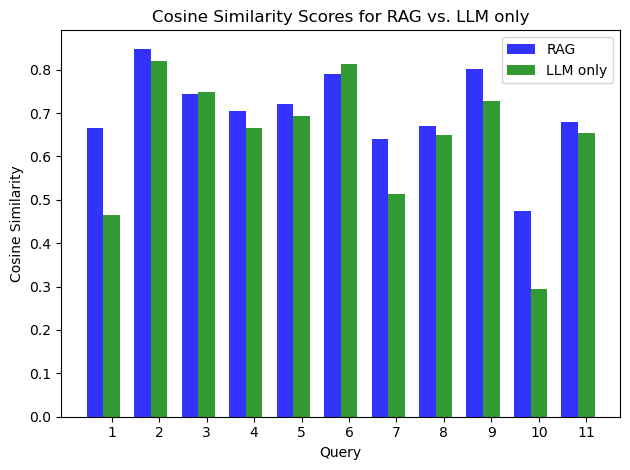

In [34]:
# Create a bar chart comparing the cosine similarity scores for the RAG and LLM
import matplotlib.pyplot as plt

# Data
queries = ['How does a quick start work?', 'What are common coxswain calls?', 'How do I enter a stake boat?', 'What are the top 3 priorities of a coxswain?', 'How does the steering rudder in an eight work?', 'At the catch, how should a rower’s blade enter the water? What can a coxswain say to help the rower get the blade in quick and sharp at the front end?']
rag_scores = [cosine_sim_q1_rag, cosine_sim_q2_rag, cosine_sim_q3_rag, cosine_sim_q4_rag, cosine_sim_q5_rag, cosine_sim_q6_rag, cosine_sim_q7_rag, cosine_sim_q8_rag, cosine_sim_q9_rag, cosine_sim_q10_rag, cosine_sim_q11_rag]
llm_scores = [cosine_sim_q1_llm, cosine_sim_q2_llm, cosine_sim_q3_llm, cosine_sim_q4_llm, cosine_sim_q5_llm, cosine_sim_q6_llm, cosine_sim_q7_llm, cosine_sim_q8_llm, cosine_sim_q9_llm, cosine_sim_q10_llm, cosine_sim_q11_llm]

# Plot
fig, ax = plt.subplots()
index = np.arange(len(rag_scores))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, rag_scores, bar_width,
alpha=opacity,
color='b',
label='RAG')

rects2 = plt.bar(index + bar_width, llm_scores, bar_width,
alpha=opacity,
color='g',
label='LLM only')

plt.xlabel('Query')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Scores for RAG vs. LLM only')
plt.xticks(index + bar_width, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
plt.legend()

plt.tight_layout()
plt.show()

# Save the cosine similarity scores to a CSV file
import csv

# Data
data = zip(queries, rag_scores, llm_scores)

# Write to CSV
with open('cosine_similarity_scores.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Query', 'RAG', 'LLM'])
    for row in data:
        writer.writerow(row)